## Data Preprocessing

In [1]:
import torch
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Shows the GPU name

True
Tesla T4


### Imports

In [2]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Text Preprocessor Class

In [3]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        """Comprehensive text cleaning for product search"""
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Remove special characters but keep important ones for products
        text = re.sub(r'[^\w\s\-\.]', ' ', text)

        # Handle measurements and units (keep them meaningful)
        text = re.sub(r'(\d+)\s*-\s*(\w+)', r'\1\2', text)  # "12-gauge" -> "12gauge"
        text = re.sub(r'(\d+)\s*(\w+)', r'\1\2', text)      # "1 gal" -> "1gal"

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def extract_features(self, text):
        """Extract meaningful features from product text"""
        if pd.isna(text):
            return ""

        text = str(text).lower()
        features = []

        # Extract brand information (first few words often contain brand)
        words = text.split()
        if len(words) > 0:
            potential_brand = words[0]
            features.append(f"brand_{potential_brand}")

        # Extract measurements
        measurements = re.findall(r'\d+(?:\.\d+)?(?:inch|in|ft|gal|gauge|lb)', text)
        features.extend([f"measure_{m}" for m in measurements])

        colors = re.findall(r'\b(?:black|white|brown|gray|grey|red|blue|green|yellow|silver|gold)\b', text)
        features.extend([f"color_{c}" for c in colors])

        return " ".join(features)

    def remove_stopwords_and_stem(self, text):
        """Remove stopwords and apply stemming"""
        if pd.isna(text):
            return ""

        words = text.split()
        important_words = {'with', 'for', 'in', 'on', 'over', 'under'}
        filtered_words = []

        for word in words:
            if word not in self.stop_words or word in important_words:
                stemmed = self.stemmer.stem(word)
                filtered_words.append(stemmed)

        return " ".join(filtered_words)


### Data Preprocessor Class

In [4]:
class DataPreprocessor:
    def __init__(self, csv_path, name):
        self.df = pd.read_csv(csv_path)
        self.name = name

    def __remove_duplicates_and_nulls(self):
        print(f"Before removing duplicates and nulls: {self.df.shape}")
        self.df = self.df.drop_duplicates()
        required_columns = ['product_title', 'search_term']
        if 'relevance' in self.df.columns:
            required_columns.append('relevance')
        self.df = self.df.dropna(subset=required_columns)
        print(f"After removing duplicates and nulls: {self.df.shape}")

    def __preprocess_text(self):
        text_preprossor = TextPreprocessor()
        self.df['search_term_clean'] = self.df['search_term'].apply(text_preprossor.clean_text)
        self.df['product_title_clean'] = self.df['product_title'].apply(text_preprossor.clean_text)

        self.df['search_term_features'] = self.df['search_term'].apply(text_preprossor.extract_features)
        self.df['product_title_features'] = self.df['product_title'].apply(text_preprossor.extract_features)

        self.df['search_term'] = self.df['search_term_clean'] + " " + self.df['search_term_features']
        self.df['product_title'] = self.df['product_title_clean'] + " " + self.df['product_title_features']

        self.df['search_term'] = self.df['search_term'].apply(text_preprossor.remove_stopwords_and_stem)
        self.df['product_title'] = self.df['product_title'].apply(text_preprossor.remove_stopwords_and_stem)

    def __remove_outliers(self):
        Q1 = self.df['relevance'].quantile(0.25)
        Q3 = self.df['relevance'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        self.df['relevance'] = self.df['relevance'].clip(lower_bound, upper_bound)

        outliers_count = len(self.df[(self.df['relevance'] < lower_bound) | (self.df['relevance'] > upper_bound)])
        print(f"Number of outliers: {outliers_count}")

    def __remove_unnecessary_columns(self):
        self.df = self.df.drop(
            columns=[
                'search_term_clean',
                'product_title_clean',
                'search_term_features',
                'product_title_features',
                'product_uid',
                'id'
            ]
        )

    def __normalize_relevance(self):
        scaler = MinMaxScaler()
        self.df['relevance'] = scaler.fit_transform(self.df[['relevance']])

    def set_df_and_name(self, csv_path, name):
        self.df = pd.read_csv(csv_path)
        self.name = name

    def get_df(self):
        return self.df

    def preprocess(self):
        self.__remove_duplicates_and_nulls()
        self.__preprocess_text()
        self.__remove_unnecessary_columns()
        if self.name == 'train':
            self.__remove_outliers()
            self.__normalize_relevance()
        print(f"Final {self.name} dataset shape: {self.df.shape}")
        print(self.df.head())
        print("--" * 80)

### Preprocessing Steps

In [5]:
data_preprocessor = DataPreprocessor('csv/clean/train.csv', 'train')
data_preprocessor.preprocess()
train_df = data_preprocessor.get_df()

Before removing duplicates and nulls: (74067, 5)
After removing duplicates and nulls: (74067, 5)
Number of outliers: 0
Final train dataset shape: (74067, 3)
                                       product_title  \
0        simpson strong-ti 12gaug angl brand_simpson   
1        simpson strong-ti 12gaug angl brand_simpson   
2  behr premium textur deckov 1gal. sc-141tugboat...   
3  delta vero 1handl shower faucet trim kit in ch...   
4  delta vero 1handl shower faucet trim kit in ch...   

                   search_term  relevance  
0      angl bracket brand_angl      1.000  
1            l bracket brand_l      0.750  
2         deck over brand_deck      1.000  
3  rain shower head brand_rain      0.665  
4     shower faucet brand_show      0.835  
----------------------------------------------------------------------------------------------------------------------------------------------------------------


## Model Training

In [6]:
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import os
os.environ["WANDB_DISABLED"] = "true"

In [7]:
train_temp_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_temp_df, test_size=0.2, random_state=42)

train_examples = [
    InputExample(texts=[s, p], label=float(r))
    for s, p, r in zip(train_df['search_term'], train_df['product_title'], train_df['relevance'])
]

val_examples = [
    InputExample(texts=[s, p], label=float(r))
    for s, p, r in zip(val_df['search_term'], val_df['product_title'], val_df['relevance'])
]

print("Train examples size: ", len(train_examples))
print("Val examples size: ", len(val_examples))
print("Test dataset size: ", len(test_df))

Train examples size:  47402
Val examples size:  11851
Test dataset size:  14814


In [8]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=16)

val_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_examples, name='val')

model = SentenceTransformer('all-MiniLM-L6-v2')
train_loss = losses.CosineSimilarityLoss(model)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=val_evaluator,
    epochs=3,
    warmup_steps=100,
    evaluation_steps=100,
    show_progress_bar=True,
    output_path='fine_tuned_model'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Val Pearson Cosine,Val Spearman Cosine
100,No log,No log,0.399392,0.386171
200,No log,No log,0.427850,0.418011
300,No log,No log,0.438373,0.427572
400,No log,No log,0.448315,0.438727
500,0.063700,No log,0.445147,0.428885
600,0.063700,No log,0.461311,0.450111
700,0.063700,No log,0.465463,0.456904
800,0.063700,No log,0.462088,0.452139
900,0.063700,No log,0.464977,0.457368
1000,0.057600,No log,0.462674,0.452463


Step,Training Loss,Validation Loss,Val Pearson Cosine,Val Spearman Cosine
100,No log,No log,0.399392,0.386171
200,No log,No log,0.427850,0.418011
300,No log,No log,0.438373,0.427572
400,No log,No log,0.448315,0.438727
500,0.063700,No log,0.445147,0.428885
600,0.063700,No log,0.461311,0.450111
700,0.063700,No log,0.465463,0.456904
800,0.063700,No log,0.462088,0.452139
900,0.063700,No log,0.464977,0.457368
1000,0.057600,No log,0.462674,0.452463


## Model Testing

### Using test dataframe

In [18]:
model = SentenceTransformer('fine_tuned_model')

def predict_relevance_scores(search_terms, product_titles, batch_size=32):
    """
    Predict relevance scores between search terms and product titles
    Returns scores between 0 and 1 (higher = more relevant)
    """
    relevance_scores = []

    for i in range(0, len(search_terms), batch_size):
        batch_search = search_terms[i:i+batch_size]
        batch_products = product_titles[i:i+batch_size]

        search_embeddings = model.encode(batch_search, convert_to_tensor=True)
        product_embeddings = model.encode(batch_products, convert_to_tensor=True)

        similarities = util.cos_sim(search_embeddings, product_embeddings)

        batch_scores = [similarities[j][j].item() for j in range(len(batch_search))]
        relevance_scores.extend(batch_scores)

    return relevance_scores

print("Predicting relevance scores...")
predicted_scores = predict_relevance_scores(
    test_df['search_term'].tolist(),
    test_df['product_title'].tolist()
)

test_df['predicted_relevance'] = predicted_scores

print(f"Predicted relevance scores (sample):")
print(test_df[['search_term', 'product_title', 'predicted_relevance']].head(10))

print(f"\nPredicted score statistics:")
print(f"Mean: {np.mean(predicted_scores):.4f}")
print(f"Std: {np.std(predicted_scores):.4f}")
print(f"Min: {np.min(predicted_scores):.4f}")
print(f"Max: {np.max(predicted_scores):.4f}")

print(f"\nActual relevance statistics:")
print(f"Mean: {test_df['relevance'].mean():.4f}")
print(f"Std: {test_df['relevance'].std():.4f}")
print(f"Min: {test_df['relevance'].min():.4f}")
print(f"Max: {test_df['relevance'].max():.4f}")


Predicting relevance scores...
Predicted relevance scores (sample):
                                             search_term  \
13534         commerci cordless drill set brand_commerci   
29748                         15amp extens cord brand_15   
20225  30inch under cabinet stainless rang hood brand_30   
5169                         heat shrink tube brand_heat   
49860            stainless steel hardwar brand_stainless   
29185                              cargo mat brand_cargo   
53859                             ceil hanger brand_ceil   
30878                       huski work bemch brand_huski   
26969                black bench brand_black color_black   
41776                      cfl candelabra 100w brand_cfl   

                                           product_title  predicted_relevance  
13534  dewalt 20volt max lithium-ion cordless combo k...             0.773827  
29748  cerrowir 15amp 125volt stay plug replac end br...             0.699751  
20225  broan allur 2seri 30in. 

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

y_true = test_df['relevance'].values
y_pred = test_df['predicted_relevance'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

pearson_corr, pearson_p = pearsonr(y_true, y_pred)
spearman_corr, spearman_p = spearmanr(y_true, y_pred)

print("=" * 80)
print("MODEL EVALUATION METRICS")
print("=" * 80)
print(f"Mean Squared Error (MSE):     {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE):    {mae:.6f}")
print(f"R² Score:                     {r2:.6f}")
print(f"Pearson Correlation:          {pearson_corr:.6f} (p-value: {pearson_p:.2e})")
print(f"Spearman Correlation:         {spearman_corr:.6f} (p-value: {spearman_p:.2e})")

print(f"\nADDITIONAL ANALYSIS:")
print(f"Number of samples:            {len(y_true)}")
print(f"Prediction range:             [{y_pred.min():.4f}, {y_pred.max():.4f}]")
print(f"Actual range:                 [{y_true.min():.4f}, {y_true.max():.4f}]")

error_thresholds = [0.1, 0.2, 0.3, 0.5]
print(f"\nPREDICTION ACCURACY BY ERROR THRESHOLD:")
for threshold in error_thresholds:
    within_threshold = np.abs(y_true - y_pred) <= threshold
    percentage = (within_threshold.sum() / len(y_true)) * 100
    print(f"Within ±{threshold}: {percentage:.1f}% ({within_threshold.sum()}/{len(y_true)} samples)")

print(f"\n" + "=" * 80)
print("PREDICTION EXAMPLES")
print("=" * 80)

errors = np.abs(y_true - y_pred)
best_indices = np.argsort(errors)[:5]
worst_indices = np.argsort(errors)[-5:]

print("TOP 5 BEST PREDICTIONS (smallest error):")
for i, idx in enumerate(best_indices):
    print(f"{i+1}. Actual: {y_true[idx]:.4f}, Predicted: {y_pred[idx]:.4f}, Error: {errors[idx]:.4f}")
    print(f"   Search: {test_df.iloc[idx]['search_term'][:50]}...")
    print(f"   Product: {test_df.iloc[idx]['product_title'][:50]}...")
    print("-" * 60)

print("\nTOP 5 WORST PREDICTIONS (largest error):")
for i, idx in enumerate(worst_indices):
    print(f"{i+1}. Actual: {y_true[idx]:.4f}, Predicted: {y_pred[idx]:.4f}, Error: {errors[idx]:.4f}")
    print(f"   Search: {test_df.iloc[idx]['search_term'][:50]}...")
    print(f"   Product: {test_df.iloc[idx]['product_title'][:50]}...")
    print("-" * 60)


MODEL EVALUATION METRICS
Mean Squared Error (MSE):     0.051464
Root Mean Squared Error (RMSE): 0.226857
Mean Absolute Error (MAE):    0.182865
R² Score:                     0.273813
Pearson Correlation:          0.524287 (p-value: 0.00e+00)
Spearman Correlation:         0.519881 (p-value: 0.00e+00)

ADDITIONAL ANALYSIS:
Number of samples:            14814
Prediction range:             [0.0473, 1.0000]
Actual range:                 [0.0000, 1.0000]

PREDICTION ACCURACY BY ERROR THRESHOLD:
Within ±0.1: 31.1% (4600/14814 samples)
Within ±0.2: 62.7% (9289/14814 samples)
Within ±0.3: 82.3% (12186/14814 samples)
Within ±0.5: 97.1% (14381/14814 samples)

PREDICTION EXAMPLES
TOP 5 BEST PREDICTIONS (smallest error):
1. Actual: 0.5000, Predicted: 0.5000, Error: 0.0000
   Search: metal plate 9x12 brand_met...
   Product: hubbel taymac 1gang blank maxi metal wall plate - ...
------------------------------------------------------------
2. Actual: 0.6650, Predicted: 0.6650, Error: 0.0000
   Search:

CONFUSION MATRIX ANALYSIS
Relevance Categories:
  - Very Low: [0.0, 0.2)
  - Low: [0.2, 0.4)
  - Medium: [0.4, 0.6)
  - High: [0.6, 0.8)
  - Very High: [0.8, 1.0]

Overall Classification Accuracy: 0.3826


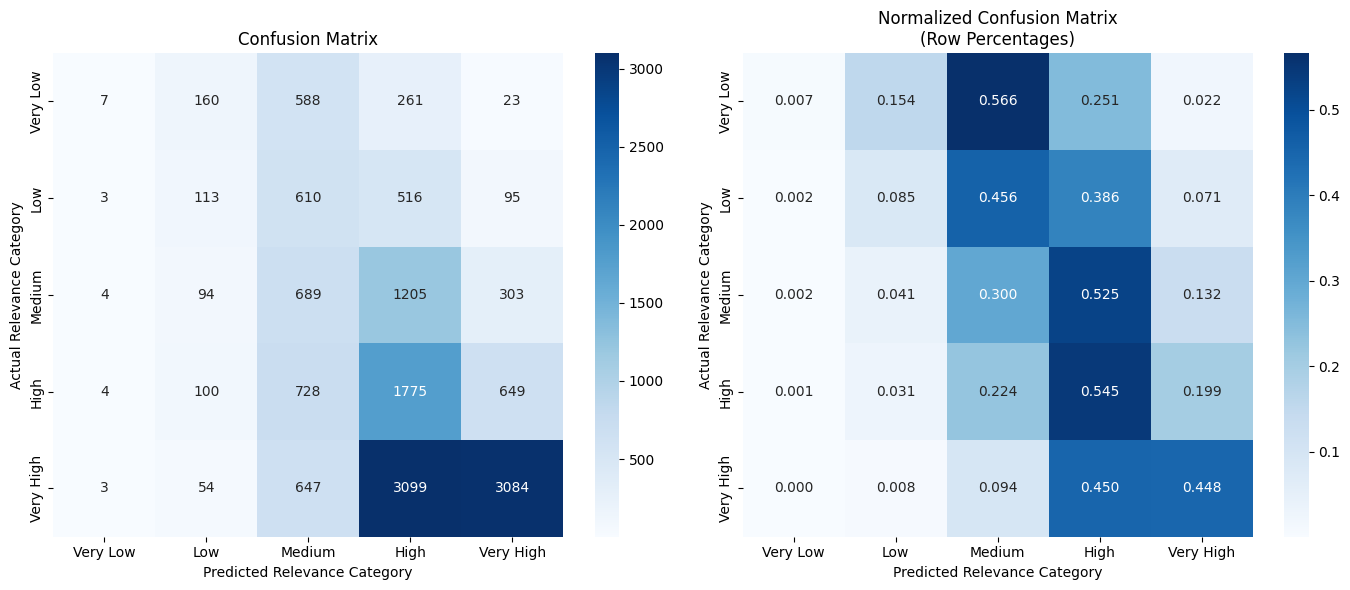


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Very Low       0.33      0.01      0.01      1039
         Low       0.22      0.08      0.12      1337
      Medium       0.21      0.30      0.25      2295
        High       0.26      0.55      0.35      3256
   Very High       0.74      0.45      0.56      6887

    accuracy                           0.38     14814
   macro avg       0.35      0.28      0.26     14814
weighted avg       0.48      0.38      0.39     14814



In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def categorize_relevance(scores, thresholds=[0.2, 0.4, 0.6, 0.8]):
    """
    Convert continuous relevance scores into 5 categories:
    - Very Low: [0.0, 0.2)
    - Low: [0.2, 0.4)
    - Medium: [0.4, 0.6)
    - High: [0.6, 0.8)
    - Very High: [0.8, 1.0]
    """
    categories = []
    for score in scores:
        if score < thresholds[0]:
            categories.append('Very Low')
        elif score < thresholds[1]:
            categories.append('Low')
        elif score < thresholds[2]:
            categories.append('Medium')
        elif score < thresholds[3]:
            categories.append('High')
        else:
            categories.append('Very High')
    return categories

y_true_cat = categorize_relevance(y_true)
y_pred_cat = categorize_relevance(y_pred)

labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)

accuracy = accuracy_score(y_true_cat, y_pred_cat)
class_report = classification_report(y_true_cat, y_pred_cat, labels=labels)

print("=" * 80)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 80)
print(f"Relevance Categories:")
print(f"  - Very Low: [0.0, 0.2)")
print(f"  - Low: [0.2, 0.4)")
print(f"  - Medium: [0.4, 0.6)")
print(f"  - High: [0.6, 0.8)")
print(f"  - Very High: [0.8, 1.0]")
print(f"\nOverall Classification Accuracy: {accuracy:.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Relevance Category')
plt.ylabel('Actual Relevance Category')

plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix\n(Row Percentages)')
plt.xlabel('Predicted Relevance Category')
plt.ylabel('Actual Relevance Category')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 80)
print(class_report)

### Manual Testing

In [22]:
def semantic_search_test_data(query, top_k=5):
    """
    Search for most relevant products in test data for a given query
    """
    text_preprocessor = TextPreprocessor()
    query_clean = text_preprocessor.clean_text(query)
    query_features = text_preprocessor.extract_features(query)
    query_processed = text_preprocessor.remove_stopwords_and_stem(query_clean + " " + query_features)

    unique_products = test_df['product_title'].unique()

    query_embedding = model.encode(query_processed, convert_to_tensor=True)
    product_embeddings = model.encode(unique_products, convert_to_tensor=True)

    hits = util.semantic_search(query_embedding, product_embeddings, top_k=top_k)[0]

    print(f"\nTop {top_k} products for query: '{query}'")
    print("-" * 80)
    for i, hit in enumerate(hits):
        product_idx = hit['corpus_id']
        score = hit['score']
        product = unique_products[product_idx]

        original_product = test_df[test_df['product_title'] == product]['product_title'].iloc[0]

        print(f"{i+1}. Score: {score:.4f}")
        print(f"   Product: {original_product}")
        print()

test_queries = [
    "samsung washer",
    "concrete mix",
    "led lights",
    "fence post",
    "shower faucet"
]

for query in test_queries:
    semantic_search_test_data(query, top_k=3)


Top 3 products for query: 'samsung washer'
--------------------------------------------------------------------------------
1. Score: 0.9130
   Product: samsung 4.2cu. ft. front load washer with steam in platinum energi star brand_samsung

2. Score: 0.9129
   Product: samsung 4.2cu. ft. front load washer with steam in merlot energi star brand_samsung

3. Score: 0.9108
   Product: samsung 4.5cu. ft. high-effici front load washer with steam in onyx energi star brand_samsung


Top 3 products for query: 'concrete mix'
--------------------------------------------------------------------------------
1. Score: 0.8927
   Product: quikret 50lb. fast-set concret mix brand_quikret

2. Score: 0.8905
   Product: rapid set 60lb. concret mix brand_rapid

3. Score: 0.8815
   Product: quikret 60lb. concret mix brand_quikret


Top 3 products for query: 'led lights'
--------------------------------------------------------------------------------
1. Score: 0.9172
   Product: irradi wall-mount dark bronz 

## Saving model from colab to local

In [23]:
!zip -r fine_tuned_model.zip fine_tuned_model

  adding: fine_tuned_model/ (stored 0%)
  adding: fine_tuned_model/model.safetensors (deflated 8%)
  adding: fine_tuned_model/config.json (deflated 48%)
  adding: fine_tuned_model/special_tokens_map.json (deflated 80%)
  adding: fine_tuned_model/README.md (deflated 68%)
  adding: fine_tuned_model/2_Normalize/ (stored 0%)
  adding: fine_tuned_model/eval/ (stored 0%)
  adding: fine_tuned_model/eval/similarity_evaluation_val_results.csv (deflated 31%)
  adding: fine_tuned_model/sentence_bert_config.json (deflated 4%)
  adding: fine_tuned_model/vocab.txt (deflated 53%)
  adding: fine_tuned_model/config_sentence_transformers.json (deflated 34%)
  adding: fine_tuned_model/modules.json (deflated 62%)
  adding: fine_tuned_model/tokenizer.json (deflated 71%)
  adding: fine_tuned_model/1_Pooling/ (stored 0%)
  adding: fine_tuned_model/1_Pooling/config.json (deflated 57%)
  adding: fine_tuned_model/tokenizer_config.json (deflated 73%)


In [24]:
from google.colab import files
files.download('fine_tuned_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>